In [1]:
from datetime import datetime
from satpy import Scene, find_files_and_readers
from satpy.writers import get_enhanced_image
from pyresample import create_area_def
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd

For sentinel data you need to have all individual directories (with the corresponding files for the swat) in a base folder. Here you give the address of the base folder, brcause the reader extracts information from the names of the individual S3 directories.
In my example I have pleaced all directories in a local base directory named sen

# Florida Bay

In [2]:
files = find_files_and_readers(sensor='olci',
                               start_time=datetime(2022, 1, 18, 15, 25),
                               end_time=datetime(2022, 1, 18, 15, 29),
                               base_dir="sen/",
                               reader='olci_l1b')

files
scn = Scene(filenames=files)

scn.load(['true_color'])
scn.show('true_color')

my_area = create_area_def('my_area', {'proj': 'lcc', 'lon_0': -91., 'lat_0': 29.5, 'lat_1': 29.5, 'lat_2': 29.5},
                          width=1200, height=700,
                          area_extent=[-82, 26, -80, 24], units='degrees')
new_scn = scn.resample(my_area)
#generate RGB from true color
rgb = get_enhanced_image(new_scn['true_color'])
#extract projection and lon lat from products
crs = new_scn['true_color'].attrs['area'].to_cartopy_crs()

100%|█████████████████████████████████████████| 52/52 [00:00<00:00, 1993.16kB/s]
No rsr file /Users/veronicaruizxomchuk/Library/Application Support/pyspectral/rsr_olci_Sentinel-3A.h5 on disk
4811182it [00:02, 2259918.96it/s]


In [3]:
# I am looking into the locations of the sampling sites that are stored
# in a text file
path = 'FB_sites.csv'

#this loads the file and dentifies the date column
df = pd.read_csv(path, parse_dates=['Date'])
#if you explore the file you will se that
#lat and lon are in the same column called coordinates
# so we need to split them and create a individual columns for them
df[['lat', 'lon']] = df.Coordinates.str.split(',', expand=True).astype(float)
# this gets the short name from the site colum (for ploting purposes)
# and puts it in a column called ID
df['ID'] = df.Site.str.extract(r'\(([^)]+)')
df

,Transect,Date,Site,Coordinates,lat,lon,ID
0,East,2022-01-15,Trout Cove (TRC),"25.20691, -80.53461",25.20691,-80.53461,TRC
1,East,2022-01-15,South Nest Key (SN),"25.13093, -80.51186",25.13093,-80.51186,SN
2,East,2022-01-15,Upper Cross (UC),"25.05446, -80.56281",25.05446,-80.56281,UC
3,East,2022-01-15,East Key (EK),"24.99625, -80.61240",24.99625,-80.61240,EK
4,East,2022-01-15,Manatee Key (MK),"25.07055, -80.62050",25.07055,-80.62050,MK
5,Central,2022-01-18,Terrapin Bay (TB),"25.13956, -80.71870",25.13956,-80.71870,TB
6,Central,2022-01-18,Beat Ass Lake (BAL),"25.06083, -80.65025",25.06083,-80.65025,BAL
7,Central,2022-01-18,Porpoise Lake (PL),"25.02528, -80.64328",25.02528,-80.64328,PL
8,Central,2022-01-14,Twin Key (TK),"24.95409, -80.71839",24.95409,-80.71839,TK
9,Central,2022-01-18,Little Madeira Bay (LM),"25.17312, -80.63242",25.17312,-80.63242,LM


/Users/veronicaruizxomchuk/opt/anaconda3/envs/satpy/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in log
  return func(*(_execute_task(a, cache) for a in args))
/Users/veronicaruizxomchuk/opt/anaconda3/envs/satpy/lib/python3.7/site-packages/satpy/modifiers/angles.py:485: RuntimeWarning: invalid value encountered in log
  grad_factor = 1. - np.log(grad_factor + 1) / np.log(2)
/Users/veronicaruizxomchuk/opt/anaconda3/envs/satpy/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in log
  return func(*(_execute_task(a, cache) for a in args))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


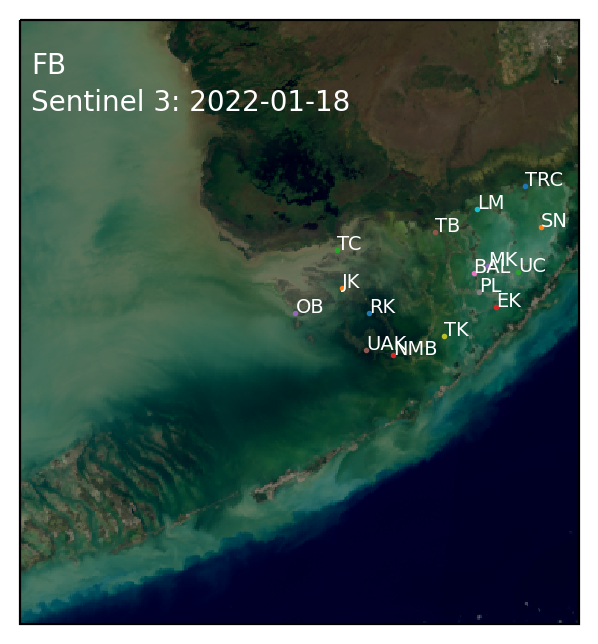

In [4]:
# Plot a tru color map, with stations
fig =  plt.figure(dpi=200)
ax = plt.subplot(projection=crs)
ax.set_extent([-81.5, -80.5, 24.5, 25.5])
rgb.data.plot.imshow(rgb='bands', transform=crs, ax=ax)
for index, row in df.iterrows():
    ax.text(row['lon'], row['lat'], row['ID'], transform=ccrs.PlateCarree(), color='w', size=7)
    ax.scatter(x=row['lon'], y=row['lat'], label=row['ID'], transform=ccrs.PlateCarree(), s=1)
ax.set_title('')
ax.text(.02, .91, 'FB', transform=ax.transAxes, color='w')
ax.text(.02, .85, 'Sentinel 3: 2022-01-18', transform=ax.transAxes, color='w')
fig.savefig('FB_sations.png')

# GOMEX SPRING

In [5]:
files = find_files_and_readers(sensor='olci',
                               start_time=datetime(2022, 4, 21),
                               end_time=datetime(2022, 4, 22),
                               base_dir="sen/",
                               reader='olci_l1b')

files
scn = Scene(filenames=files)

scn.load(['true_color'])

In [6]:
path = 'GOMEX_sites.csv'
df = pd.read_csv(path)

In [7]:
my_area = create_area_def('my_area', {'proj': 'lcc', 'lon_0': -91.5, 'lat_0': 29.5, 'lat_1': 29.5, 'lat_2': 29.5},
                          width=1200, height=700,
                          area_extent=[-92.5, 30.5, -87, 28], units='degrees')
new_scn = scn.resample(my_area)
#generate RGB from true color
rgb = get_enhanced_image(new_scn['true_color'])
#extract projection and lon lat from products
crs = new_scn['true_color'].attrs['area'].to_cartopy_crs()

/Users/veronicaruizxomchuk/opt/anaconda3/envs/satpy/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in log
  return func(*(_execute_task(a, cache) for a in args))
/Users/veronicaruizxomchuk/opt/anaconda3/envs/satpy/lib/python3.7/site-packages/satpy/modifiers/angles.py:485: RuntimeWarning: invalid value encountered in log
  grad_factor = 1. - np.log(grad_factor + 1) / np.log(2)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


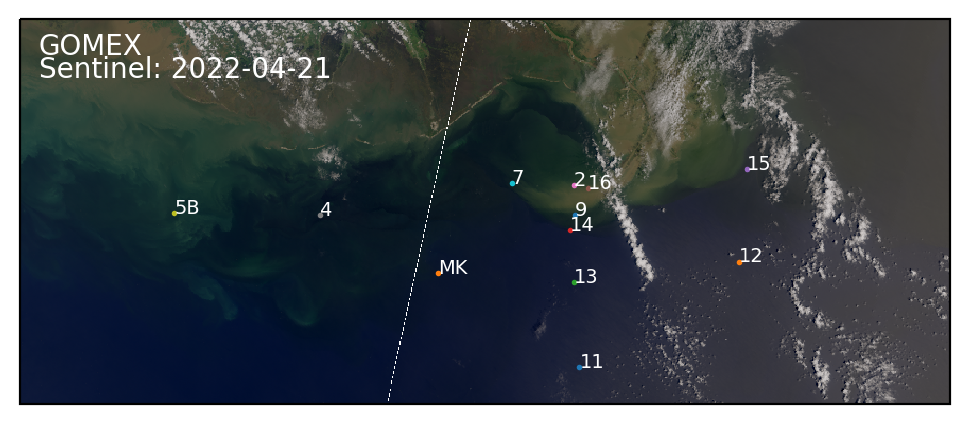

In [8]:
fig =  plt.figure(dpi=200)
ax = plt.subplot(projection=crs)

ax.set_extent([-92, -88, 28, 29.5])
rgb.data.plot.imshow(rgb='bands', transform=crs, ax=ax)
for index, row in df.iterrows():
    ax.text(row['Lon'], row['Lat'], row['Station'].split('.')[-1], transform=ccrs.PlateCarree(), color='w', size=7)
    ax.scatter(x=row['Lon'], y=row['Lat'], label=row['Station'], transform=ccrs.PlateCarree(), s=1)
ax.set_title('')
ax.text(.02, .91, 'GOMEX', transform=ax.transAxes, color='w')
ax.text(.02, .85, 'Sentinel: 2022-04-21', transform=ax.transAxes, color='w')
fig.savefig('GOMEX_spring_stations.png')